`03-begin-image-processing-basics` (M.K. & A.L. 2021-03-30)

# Image processing basics

<a href="https://colab.research.google.com/github/computational-medicine/BMED360-2021/blob/main/Lab0-beginners-guide/03-begin-image-processing-basics.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Learning objectives

- To load a series of DICOM  files (install dedicated [pydicom](https://github.com/pydicom/pydicom) library if needed),
- Create a 3D image (numpy matrix) based on predefinied shape and data type (obtained from loaded [DICOM](https://en.wikipedia.org/wiki/DICOM) files),
- Make a visualization of 3D images ([matplotlib](https://matplotlib.org)),
- Write functions in Python programming language (as  [here](https://geo-python.github.io/2017/lessons/L4/functions.html))
- To learn a basic segmentation method ([thresholding](https://en.wikipedia.org/wiki/Thresholding_(image_processing)))

### For using Colab
**the following libraries must be `pip installed` (uncomment the following pip commands):**

In [1]:
#!pip install matplotlib

In [2]:
#!pip install seaborn

In [3]:
#!pip install pandas

In [4]:
#!pip install numpy

In [5]:
#!pip install gdown

In [6]:
#!pip install pydicom

In [7]:
#!pip install scipy

In [8]:
#!pip install nibabel

In [9]:
#!pip install nilearn

In [10]:
#!pip install dcm2niix

In [11]:
#!pip install itkwidgets

**Download a data file from Google Drive using** `gdown` (https://github.com/wkentaro/gdown)

In [12]:
import gdown
import shutil
import os

In [13]:
# https://drive.google.com/file/d/1GWwkoIuVm1t3KvNrocCBgncyAC8Sqc-D/view?usp=sharing
file_id = '1GWwkoIuVm1t3KvNrocCBgncyAC8Sqc-D'
url = 'https://drive.google.com/uc?id=%s' % file_id
output = './Lab0_data.tgz'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1GWwkoIuVm1t3KvNrocCBgncyAC8Sqc-D
To: /Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab0-beginners-guide/Lab0_data.tgz
22.2MB [00:03, 6.44MB/s]


'./Lab0_data.tgz'

Unpack the gnuziped tar-file

In [14]:
shutil.unpack_archive(output, '.')

Remove the gnuzipped tar-file after the unpacking

In [15]:
os.remove(output)

**Import all libraries needed for the tutorial**

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # this is how we usually import pandas
import numpy as np # this is how we usually import numpy
import sys # only needed to determine Python version number
import pathlib
import subprocess as subp
import matplotlib # only needed to determine Matplotlib version number
import pydicom
import scipy
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
import nilearn
from nilearn import plotting
import ipywidgets
import itkwidgets

# Enable inline plotting
%matplotlib inline

/Users/arvid/opt/anaconda3/envs/bmed360/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [17]:
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)
print('Matplotlib version ' + matplotlib.__version__)
print('Seaborn version ' + sns.__version__)
print('gdown ' + gdown.__version__)
print('Pydicom version ' + pydicom.__version__)
print('Nibabel version ' + nib.__version__)
print('Scipy version ' + scipy.__version__)
print('Nilearn version ' + nilearn.__version__)
print('ITKwidgets version ' + itkwidgets.__version__)

Python version 3.8.0 | packaged by conda-forge | (default, Nov 22 2019, 19:11:19) 
[Clang 9.0.0 (tags/RELEASE_900/final)]
Pandas version 1.2.3
Numpy version 1.19.5
Matplotlib version 3.4.1
Seaborn version 0.11.1
gdown 3.12.2
Pydicom version 2.1.2
Nibabel version 3.2.1
Scipy version 1.5.3
Nilearn version 0.7.1
ITKwidgets version 0.32.0


#### Loading series of 2D DICOM files

In this section our goal is to load all DICOM image files (im001-im126) from a selected folder and store them into one 3D matrix. We use a very handy [**pydicom**](https://github.com/pydicom/pydicom) library to load bunch of dicom files.

In [18]:
try:
    import pydicom as dicom
    print('pydicom package imported succesfully!')
except ImportError:
    print ('It seems that you have to install pydicom package.\n')

pydicom package imported succesfully!


Having all installed, we want to load images from **kiwi-data** folder. The folder might contains not only \*.dcm files, but different type files and folders as well. We have to select only DICOM files (im001-im128) and skip everything else. To make selection we can use handy functions from **os** package.

In [19]:
# find ALL files in kiwi-dcm folder    
files = os.listdir('kiwi-data')

In [20]:
# select only files (skip floders) 
files = [f for f in files if not os.path.isdir(f)]
# select files with name starts from 'im' and sort them
files = sorted([f for f in files if f.startswith('im')])  # alternatively: files.sort()
print(f"List contains {len(files)} filenames starts with 'im'")

List contains 128 filenames starts with 'im'


In [21]:
### Print the sorted file list
#files

##### YOUR TURN!
1. Miscellaneous operating system interfaces (os) i very powerful and useful package that help in basis disc operations. You can read and about its functionality e.g. here: [1](https://docs.python.org/3/library/os.html), [2](https://www.tutorialsteacher.com/python/os-module), [3](https://www.geeksforgeeks.org/os-module-python-examples/), [...](http://www.google.com). 

We think that among others the following functions are very useful:
- os.mkdir()
- os.listdir()
- os.chdir()
- os.path.isdir()
- os.paht.isfolder()
- os.path.join()

In [22]:
# Load every single DICOM structure to a list. 
# Within these structures there are both metadata and image pixel values
dcms = []
print(f'Loading:')
for f in files:
    # Join folder name and file name
    pth = os.path.join('kiwi-data', f)
    dcms.append(dicom.dcmread(pth))
  
    print(f"{len(dcms)}",end=',')
print(f"\n\nLoaded {len(dcms)} DICOM file structures")

Loading:
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,

Loaded 128 DICOM file structures


**Let's load data (pixel values) from DICOM structures into a 3D numpy matrix**

In [23]:
# Get a shape of every single 2D image e.g. from the first image in the list
rows, cols = dcms[0].pixel_array.shape
# Get the number of DICOM files (images in the whole volume)
slices = len(dcms)

# Get the pixel type of an image
pixelType = dcms[0].pixel_array.dtype
# Create an empty 3D matrix with exact shape (rows, cols, slices) and pixel type 
#  (possible pixel types: int or float; 8, 16, 32 or 64 bits)
img3d = np.zeros((rows, cols, slices), dtype=pixelType)

# Fill in 3D array with the data (pixel values) from loaded DICOM structres
for i, s in enumerate(dcms):
    img3d[:, :, i] = s.pixel_array

In [24]:
# Let's check the basic features of the 3D image
print(f'shape: {img3d.shape}') 
print(f'max: {img3d.max()}') # max value in the matrix (3D volume)
print(f'min: {img3d.min()}') # min value int the matrix  
print(f'mean: {img3d.mean():.2f}') # mean value,
print(f'dtype {img3d.dtype}') # type of each pixel (int, float; 8, 16, 32 bits)

shape: (256, 256, 128)
max: 32766
min: 71
mean: 3374.98
dtype int16


### Matplotlib visualization
Let's see what our 3D image looks like. 
We will display the middle slice in each orthogonal view

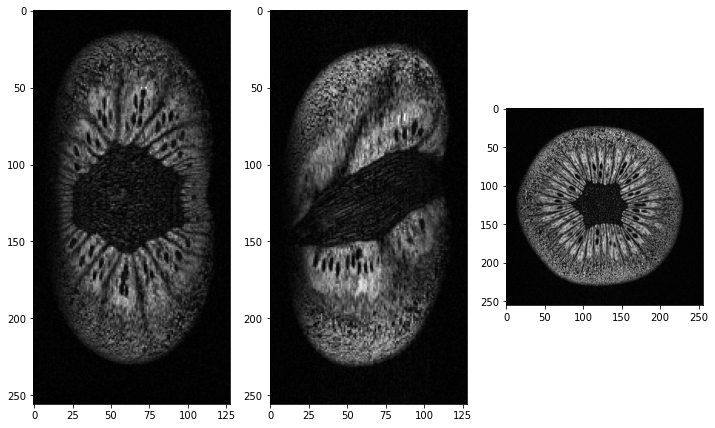

In [25]:
# Get the size in each spatial dimension, i.e rows, columns, slices
r, c, s = img3d.shape
r2, c2, s2 = r//2, c//2, s//2
cmap = 'gray'

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,8))
ax[0].imshow(img3d[r2,:,:], cmap=cmap)
ax[1].imshow(img3d[:,c2,:], cmap=cmap)
ax[2].imshow(img3d[:,:,s2], cmap=cmap)

ax[0].axis('on')
ax[1].axis('on')
ax[2].axis('on')
plt.show()

##### YOUR TURN!
1. Visit and browse for the examples and tutorials on the [Matplotlib web page](https://matplotlib.org).
2. Find all avaliable **cmap** and check out how this image looks like with diffrent cmaps.
3. Change parameter of ax[x].axis('on') to 'off' in selected or all graphs. (x is equal to 1,2,3).
4. See e.g. [here](https://geo-python.github.io/2017/lessons/L4/functions.html).
5. On functions: Why can we ommit the 'cmap' parameter during a call like in the following line?

```python
crossections(im)
```

In [26]:
# As we will display these three cross-sections a few times,
# it will be more convienient to write this piece of code as a function.

def crosssections(im, cmap='gray'):
    """
    Function displaying the middle cross sections of a 3D input image
    
    BMED360v2021
    """
    r, c, s = img3d.shape
    r2, c2, s2 = r//2, c//2, s//2

    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,8))
    ax[0].imshow(im[r2,:,:], cmap=cmap)
    ax[1].imshow(im[:,c2,:], cmap=cmap)
    ax[2].imshow(im[:,:,s2], cmap=cmap)

    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    plt.show()       

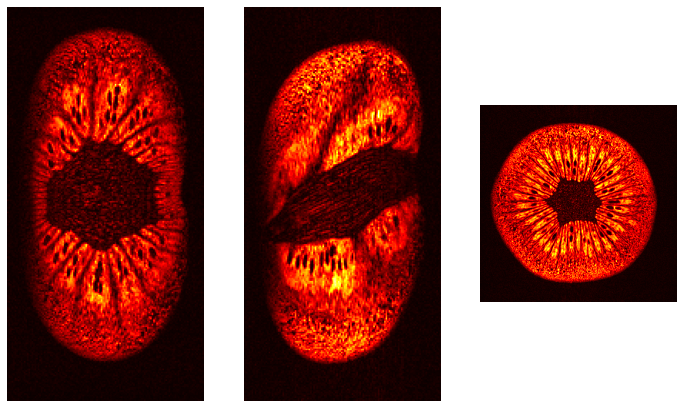

In [27]:
# Let's try our function with different color map
# hot, jet, summer, ....
crosssections(img3d, 'hot')

##### YOUR TURN!
1. Write a function that gets (prints) basic information from a 3D image. It should has the same functionality as the following lines:


```python
print(f'shape: {img3d.shape}') 
print(f'max: {img3d.max()}') # max value in the matrix (3D volume)
print(f'min: {img3d.min()}') # min value int the matrix  
print(f'mean: {img3d.mean():.2f}') # mean value,
print(f'dtype {img3d.dtype}') # type of each pixel (int, float; 8, 16, 32 bits)
```

See e.g. [here](https://geo-python.github.io/2017/lessons/L4/functions.html).

____

#### Image interpolation

In [28]:
# Above images looks "unnaturally". It seems that kiwi is elongated in a vertical direction.
# The reason of this might be a voxel anisotropy during MRI acquisition. 
# Let's check it, we can read the pixes size from the first 2D DICOM image from the set,
# and compare with distance between two conswqutive image slices.
# Pixels within all slices have the same dimensions, and the distance among all slices is equalled.

# pixel shape
xdim, ydim = dcms[0].PixelSpacing
# slice thickness
zdim = dcms[0].SliceThickness
print(f'xdim: {xdim}, ydim: {ydim}, zdim: {zdim}')

xdim: 0.234375, ydim: 0.234375, zdim: 0.5


In [29]:
# To solve this issue, we shoule resample 3D image to isotropoic voxels (each voxel siede has the sdame length)
# Let's asses new voxel thicknes

newzdim = 0.5 / 0.234375
newzdim

2.1333333333333333

In [30]:
# To resample 3D image we can use a handy function from scipy.nidimage package
from scipy import ndimage
img3dres= ndimage.zoom(img3d, [1, 1, newzdim])

In [31]:
# Let's check the image parameters now.

print(f'shape: {img3dres.shape}') 
print(f'max: {img3dres.max()}')
print(f'min: {img3dres.min()}')
print(f'mean: {img3dres.mean():.2f}')
print(f'dtype {img3dres.dtype}') 

shape: (256, 256, 273)
max: 32767
min: -3356
mean: 3386.98
dtype int16


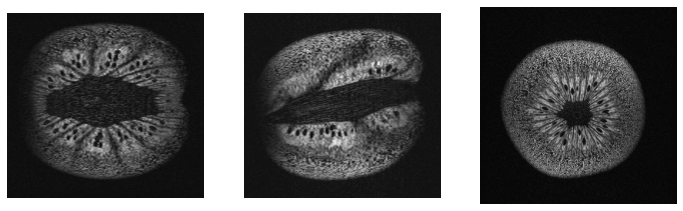

In [32]:
#Let's see how it looks like now
# TODO: WHY WE CAN OMMIT A CMAP PARAMETER DURING CALLING CROSSSECTIONS FUNCTION?
crosssections(img3dres)

##### YOUR TURN!
1. What has changed? Try to describe it. See e.g. [here](http://www.sprawls.org/mripmt/MRI10/index.html).

### Save data (images) to a disk file

Often there is a need to save some (temporary) results to a disk file. As we store our results of calculations (as well as images) in np.ndarray objects (ojbects of numpy package) there is a very easy way to save and load such a results to a file. 

##### Save as a numpy (npy) file

In [33]:
# Let's create a separate folder in which we will store all our results
import os

savefolder = 'kiwi-results'
if not os.path.exists(savefolder):
    os.mkdir(savefolder)
    print(f'"{savefolder}" folder has just been created!')
else:
     print(f'"{savefolder}" folder exists')

"kiwi-results" folder has just been created!


In [34]:
# Save our new matrix to a disc file. A *\'.npy* is a very handy numpy file format. It is easy to both 
# save and load to/from a disc, what is more these commands store all important matrix fetures like:
# shape, type of the elements in the matrix (dtype).

savefilename = 'kiwi-resampled'
savepath = os.path.join(savefolder, savefilename )
np.save(savepath, img3dres)

In [35]:
# Let's load again saved file to a new variable and check if everything is OK.
# We can use a 'savepath' variable to this purpose

animage = np.load(savepath+'.npy')

##### YOUR TURN!
1. Check all information about loaded image (stored in animage variable) with the use of written function.

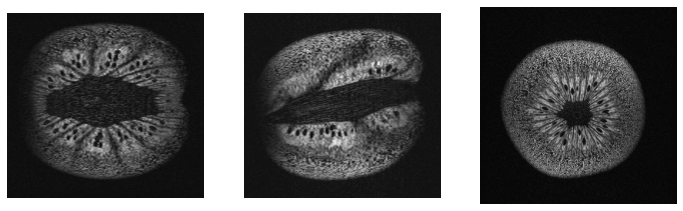

In [36]:
crosssections(animage)

In [37]:
animage.shape

(256, 256, 273)

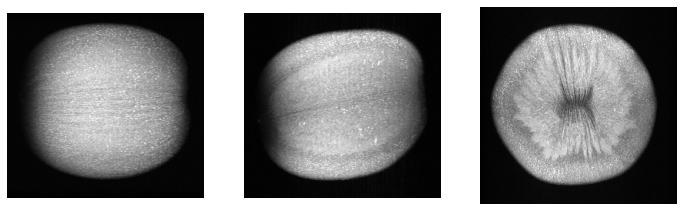

In [38]:
# Let's display Maximum Intensity Projections (MIPs) over an each image direction.

# TODO:
# 1. display images of: minimum intensity function (use min() method)
# 2. write a fuction with the same behaviour

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,8))
ax[0].imshow(animage.max(0), cmap=cmap)
ax[1].imshow(animage.max(1), cmap=cmap)
ax[2].imshow(animage.max(2), cmap=cmap)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()   

##### YOUR TURN!
1. Save each cross-section image as a separate png file to a newly created folder (named MIPS).

### THRESHOLDING

The simplest method of image segmentation is [thresholding](https://en.wikipedia.org/wiki/Thresholding_(image_processing)). It allows us to separate an image background from foreground (i.e. object of our interest from surrounding background). 

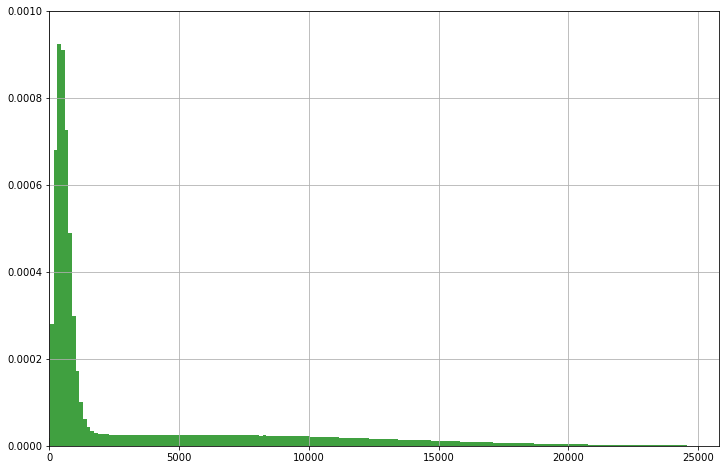

In [39]:
x = img3dres.ravel()
plt.figure(figsize=(12,8))
n, bins, patches = plt.hist(x, 256, density=True, facecolor='g', alpha=0.75)
plt.axis([0, 25800, 0, 0.001])
plt.grid(True)

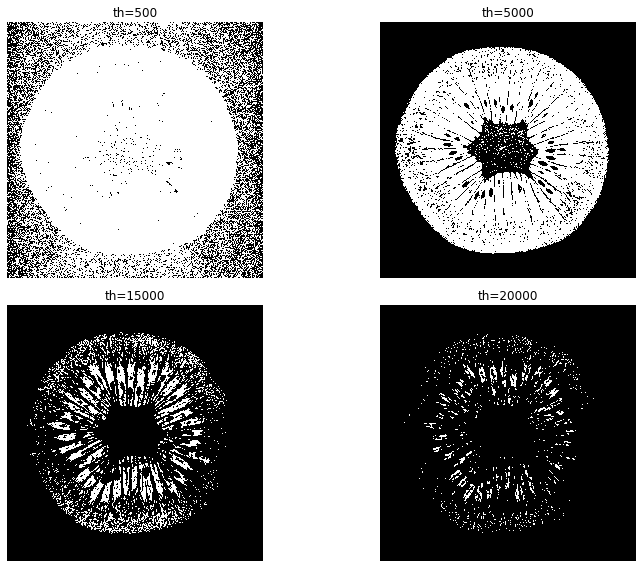

In [40]:
# Let's see how splits image regions for selected thresh values

# select the middle slice
mid = img3dres[:,:,128]

# Set 4 threh values as a list
th = [500, 5000, 15000, 20000]
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
for k, a in enumerate(ax.ravel()):
    a.imshow(np.where(mid>th[k],1,0), cmap='gray')
    a.axis('off')
    a.set_title(f'th={str(th[k])}')



plt.tight_layout()
plt.show() 

##### YOUR TURN!

1. Let's try to separate some regions of kiwi. To do this we will plot a [histogram](https://en.wikipedia.org/wiki/Image_histogram) and try to check influecne of thresh values on thresholded imagee.
2. Check the hepl for plt.hist() function from matplotlib package. Change some of avaliable function parameters.
3. Try to explain the shape of histogram we received.
4. Based on histogram shape test a number of thres values and set the best to get the best result.

### Convert DICOM to NIFTI

`dcm2niix` is a designed to convert (neuro)imaging data from the DICOM format to the NIfTI format (https://github.com/rordenlab/dcm2niix)

**If running on Colab, uncomment the following three cells**

In [42]:
#!curl -fLO https://github.com/rordenlab/dcm2niix/releases/latest/download/dcm2niix_lnx.zip
#shutil.unpack_archive('dcm2niix_lnx.zip', '.')

In [43]:
#%%bash
#chmod +x ./dcm2niix
#./dcm2niix -h

In [44]:
# DCMCONVERT = ['./dcm2niix']

In [45]:
DCMCONVERT = !which dcm2niix

In [46]:
%%bash
dcm2niix -h

Chris Rorden's dcm2niiX version v1.0.20210317  Clang11.1.0 x86-64 (64-bit MacOS)
usage: dcm2niix [options] <in_folder>
 Options :
  -1..-9 : gz compression level (1=fastest..9=smallest, default 6)
  -a : adjacent DICOMs (images from same series always in same folder) for faster conversion (n/y, default n)
  -b : BIDS sidecar (y/n/o [o=only: no NIfTI], default y)
   -ba : anonymize BIDS (y/n, default y)
  -c : comment stored in NIfTI aux_file (provide up to 24 characters e.g. '-c first_visit')
  -d : directory search depth. Convert DICOMs in sub-folders of in_folder? (0..9, default 5)
  -e : export as NRRD instead of NIfTI (y/n, default n)
  -f : filename (%a=antenna (coil) name, %b=basename, %c=comments, %d=description, %e=echo number, %f=folder name, %g=accession number, %i=ID of patient, %j=seriesInstanceUID, %k=studyInstanceUID, %m=manufacturer, %n=name of patient, %o=mediaObjectInstanceUID, %p=protocol, %r=instance number, %s=series number, %t=time, %u=acquisition number, %v=vendor

In [47]:
def kiwi_dcm2niix(dcm_dir, nii_dir):

    pathlib.Path(nii_dir).mkdir(parents=True, exist_ok=True)
    cmd = [
        DCMCONVERT[0],
        '-d', '9',
        '-b', 'y',
        '-m', 'n',
        '-s', 'n',
        '-t', 'n',
        '-x', 'n',
        '-w', '1',
        '-z', 'y',
        '-i', 'y',
        '-f', 'kiwi_%t_%s_%p', 
        '-o', nii_dir,
        dcm_dir]

    cmd_str = " ".join(cmd)
    output = subp.check_output(cmd)  # import subprocess as subp
    print(f'output: {output} \n')
    #print('cmd_str = \n%s\n' % cmd_str)
    #os.system(cmd_str)

In [48]:
mydcm = 'kiwi-data'
mynii = 'kiwi-results'
kiwi_dcm2niix(mydcm, mynii)

output: b'Chris Rorden\'s dcm2niiX version v1.0.20210317  Clang11.1.0 x86-64 (64-bit MacOS)\nFound 128 DICOM file(s)\nConvert 128 DICOM as kiwi-results/kiwi_20050217191129_131073_RARE_high_res_axial (256x256x128x1)\nCompress: "/usr/local/bin/pigz" -b 960 -n -f -6 "kiwi-results/kiwi_20050217191129_131073_RARE_high_res_axial.nii"\nConversion required 0.665179 seconds (0.165828 for core code).\n' 



In [49]:
files = os.listdir('kiwi-results')
files = sorted([f for f in files if f.endswith('.nii.gz')])
print(f"List contains {len(files)} filenames ends with '.nii.gz'")
files

List contains 1 filenames ends with '.nii.gz'


['kiwi_20050217191129_131073_RARE_high_res_axial.nii.gz']

In [50]:
kiwi_fn = './kiwi-results/%s' % files[0]

In [51]:
img = nib.load(kiwi_fn)

In [52]:
print(f'min: {img.get_fdata().min()}, max: {img.get_fdata().max()}, mean: {img.get_fdata().mean().round(2)}')

min: 71.0, max: 32766.0, mean: 3374.98


### (Interactive) visualization

In [53]:
%matplotlib notebook

<IPython.core.display.Javascript object>


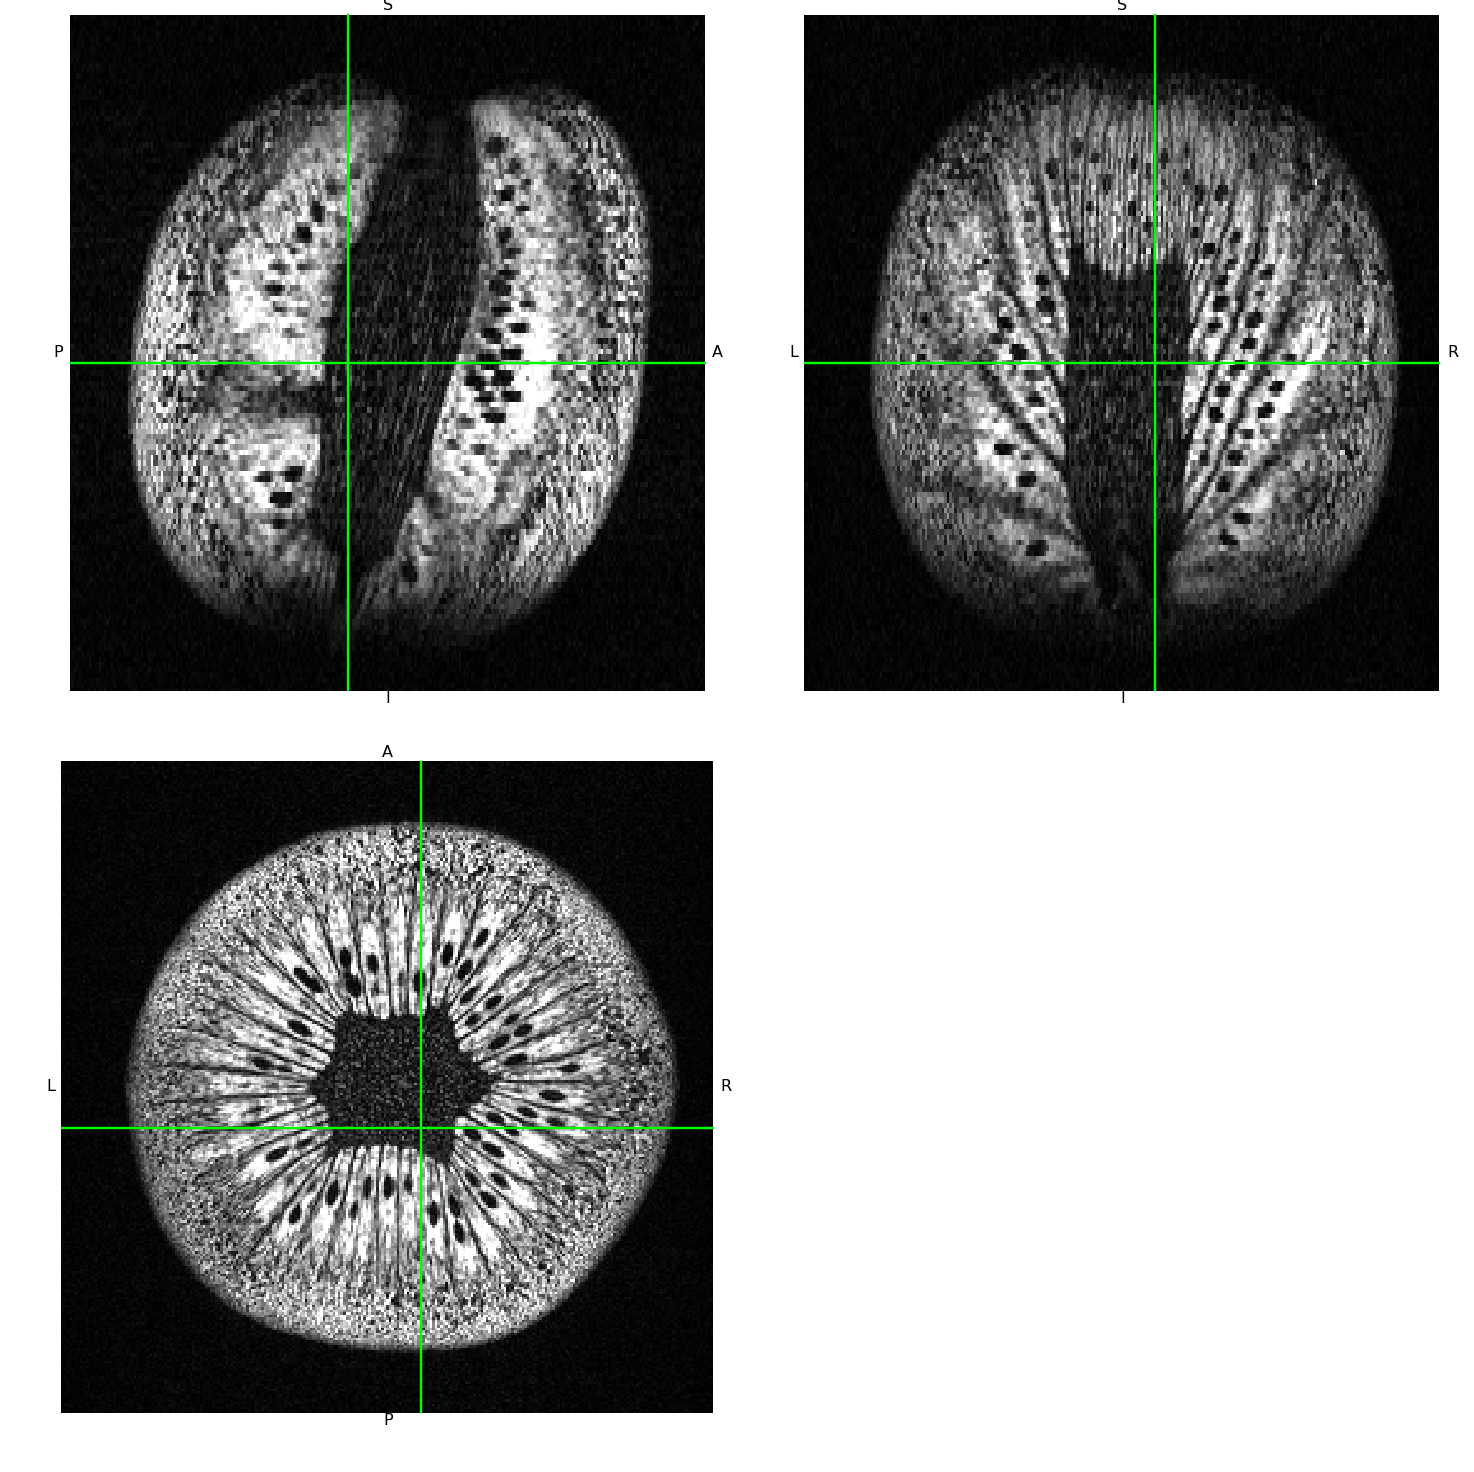

In [54]:
# Viewer from `nibabel`
OrthoSlicer3D(img.get_fdata(), affine= img.affine, title=files[0]).show()

<IPython.core.display.Javascript object>


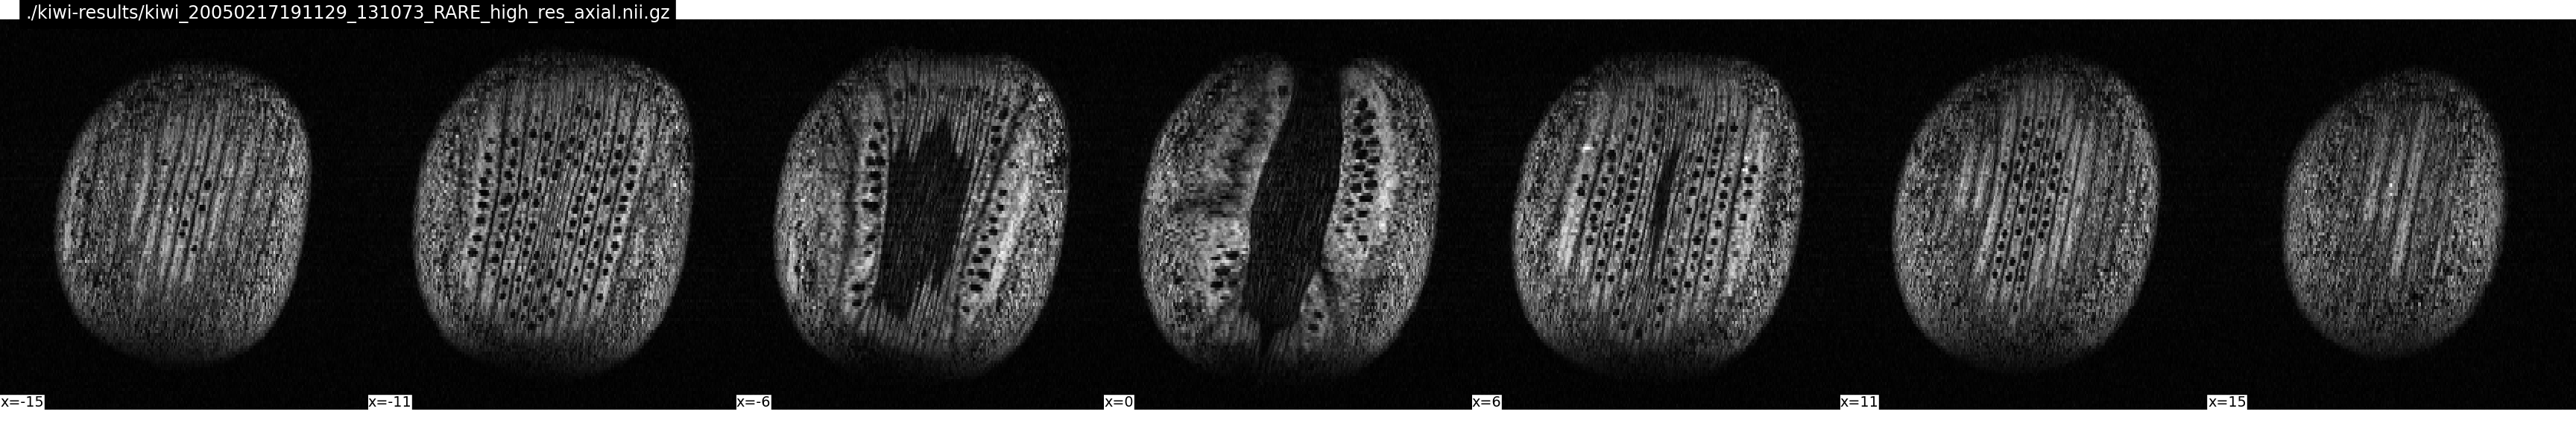

overflow encountered in short_scalars
overflow encountered in short_scalars


In [55]:
fig = plt.figure(figsize=(30, 5))
dimval = -4.0   # 0., -2., -3., -4.
dmode = 'x'  # 'x', y', 'z'
plotting.plot_anat(kiwi_fn, 
                   draw_cross=True, 
                   dim=dimval, 
                   title = kiwi_fn,
                   figure = fig,
                   display_mode=dmode)
plt.show()

In [52]:
# %matplotlib inline
# itkwidgets.view(img.get_fdata(), rotate=True, axes=True, vmin=img.get_fdata().min(), vmax=img.get_fdata().max())

##### YOUR TURN!
Explore 3D visualizations using data from https://paperswithcode.com/task/brain-tumor-segmentation